In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [2]:
# transform data into lstm inputs
def rnn_data(df, inp_cols, out_cols, look_back = 0, look_ahead = 0, output_seq=True):
    xraw = df[inp_cols].values
    yraw = df[inp_cols].values
    traw = df.index
    
    n = len(df)-look_back-look_ahead-1
    
    xdata = np.zeros((n, look_back+1, xraw.shape[1]))
    ydata = np.zeros((n, look_ahead+1, yraw.shape[1]))
    tx = np.zeros((n, look_back+1))
    ty = np.zeros((n, look_ahead+1))
    
    for i in range(n):
        lb = range(i, i+look_back+1)
        xdata[i,:,:] = xraw[lb,:]
        tx[i,:] = traw[lb]
    for i in range(n):
        la = range(i+look_back+1, i+look_back+look_ahead+2)
        ydata[i,:,:] = yraw[la,:]
        ty[i,:] = traw[la]

    assert(len(xdata.shape)==3)
    assert(xdata.shape[0] == xraw.shape[0]-look_ahead-look_back-1)
    assert(xdata.shape[2] == xraw.shape[1])
    assert(xdata.shape[1]==look_back+1)
    assert(len(ydata.shape)==3)
    assert(ydata.shape[0] == yraw.shape[0]-look_ahead-look_back-1)
    assert(ydata.shape[2] == yraw.shape[1])
    assert(ydata.shape[1] == look_ahead+1)
    
    if ~output_seq and ydata.shape[2]==1:
        ydata = ydata.squeeze(axis=2)
    else:
        mlen = max(xdata.shape[1], ydata.shape[1])
        xdata = pad_sequences(xdata, mlen, padding='post', dtype='float32')
        tx = pad_sequences(tx, mlen, padding='post', dtype='float32')
        ydata = pad_sequences(ydata, mlen, padding='pre', dtype='float32')
        ty = pad_sequences(ty, mlen, padding='pre', dtype='float32')
    
    return xdata, ydata, tx, ty

In [3]:
# create fake data
Fs = 100
f = 5
sample = 1000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)

df = pd.DataFrame(y)
df.columns = ['f1']
df.index = rng = pd.date_range('1/1/2017', periods=df.shape[0], freq='1s')

xdata, ydata, tx, ty = rnn_data(df, ['f1'], ['f1'], 20, 20, output_seq=False)
print(xdata.shape, ydata.shape)

(959, 21, 1) (959, 21)


In [4]:
# build keras model
model = Sequential()
if len(ydata.shape)==3:
    # using sequence output, y-data has dim=3
    model.add(LSTM(input_shape=(xdata.shape[1], xdata.shape[2]), units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(ydata.shape[2]))
    model.add(Activation("linear"))
else:
    # not using sequence output, y-data has dim=2
    model.add(LSTM(input_shape=(xdata.shape[1], xdata.shape[2]), units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(ydata.shape[1]))
    model.add(Activation("linear"))
    
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                2121      
_________________________________________________________________
activation_1 (Activation)    (None, 21)                0         
Total params: 72,921
Trainable params: 72,921
Non-trainable params: 0
_________________________________________________________________


In [5]:
# train model on data
model.fit(xdata, ydata, epochs=10, batch_size=100, validation_split=0.1)

Train on 863 samples, validate on 96 samples
Epoch 1/10
863/863 [==============================] - 2s - loss: 0.4768 - val_loss: 0.4296
Epoch 2/10
863/863 [==============================] - 0s - loss: 0.3463 - val_loss: 0.1717
Epoch 3/10
863/863 [==============================] - 0s - loss: 0.1103 - val_loss: 0.0360
Epoch 4/10
863/863 [==============================] - 0s - loss: 0.0364 - val_loss: 0.0143
Epoch 5/10
863/863 [==============================] - 0s - loss: 0.0258 - val_loss: 0.0042
Epoch 6/10
863/863 [==============================] - 0s - loss: 0.0210 - val_loss: 0.0024
Epoch 7/10
863/863 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0011
Epoch 8/10
863/863 [==============================] - 0s - loss: 0.0158 - val_loss: 6.8102e-04
Epoch 9/10
863/863 [==============================] - 0s - loss: 0.0143 - val_loss: 7.8033e-04
Epoch 10/10
863/863 [==============================] - 0s - loss: 0.0139 - val_loss: 3.9221e-04


In [6]:
# make the predictions
ypred = model.predict(xdata)

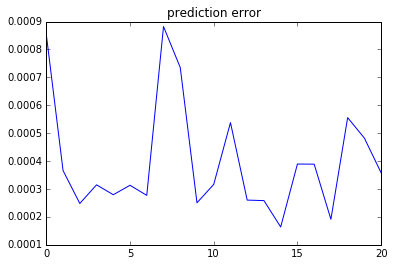

In [7]:
plt.plot(np.mean(np.power(ydata.squeeze()-ypred.squeeze(),2),axis=0));
plt.title('prediction error');

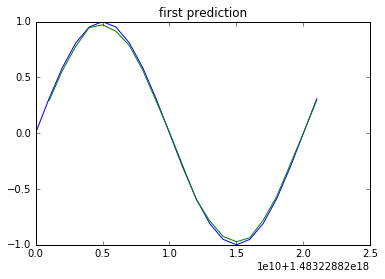

In [8]:
plt.plot(tx[0:ydata.shape[1]+1,-1], xdata[0:ydata.shape[1]+1,-1,0]);
plt.plot(ty[0,:], ypred[0,:]);
plt.title('first prediction');

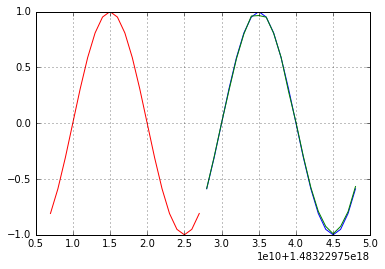

In [9]:
# testing the last row of the input data
ytmp = model.predict(xdata[-2:-1,:,:])
plt.plot(ty[-2:-1,:].squeeze(), ydata[-2:-1,:].squeeze())
plt.plot(ty[-2:-1,:].squeeze(), ytmp.squeeze())
plt.plot(tx[-2:-1,:].squeeze(), xdata[-2:-1,:,:].squeeze())
plt.grid()